# Generating GW signal to build dedicated simulation

This notebook explains how generate GW signal (h+,hx, projected strain, TDI) from source parameters using the LDC toolbox.  

## Software requirements

- git clone https://gitlab.in2p3.fr/LISA/LDC
- pip install requirements.txt
- python setup.py build_liborbits install

Look at the LDC README for more details.

- git clone https://gitlab.in2p3.fr/j2b.bayle/LISANode.git
- pip install -e .

## Generating a Galactic binary signal

In [5]:
import matplotlib.pyplot as plt
import scipy
import numpy as np
import xarray as xr
from astropy import units as u
import pandas as pd

import ldc.io.hdf5 as hdfio
from ldc.waveform.source import load_gb_catalog, load_mbhb_catalog
from ldc.lisa.noise import get_noise_model
from ldc.lisa.orbits import Orbits
from ldc.lisa.projection import ProjectedStrain
from ldc.common.series import TimeSeries, FrequencySeries
import ldc.waveform.fastGB as fastGB
from ldc.waveform.waveform import HpHc
from LISAhdf5 import LISAhdf5,ParsUnits

Let's use a verification binary from the catalog provided by the LDC software

In [6]:

DATAPATH = "/home/stefan/LDC/Radler/data"
sangria_fn = DATAPATH + "/dgb-tdi.h5"
sangria_fn = DATAPATH + "/LDC1-3_VGB_v2_FD_noiseless.hdf5"
FD5 = LISAhdf5(sangria_fn)
Nsrc = FD5.getSourcesNum()
GWs = FD5.getSourcesName()
print("Found %d GW sources: " % Nsrc, GWs)
### TOD make sure GalBin is there
if GWs[0] != "GalBinaries":
    raise NotImplementedError
p = FD5.getSourceParameters(GWs[0])
td = FD5.getPreProcessTDI()
del_t = float(p.get("Cadence"))
Tobs = float(p.get("ObservationDuration"))

### Window function used in fft
def window(tm, offs=1000.0):

    xl = offs
    ind_r = np.argwhere(tm[-1]-tm <= offs)[0][0]
    xr = tm[ind_r]
    # print (xr)
    kap = 0.005
    winl = 0.5*(1.0 + np.tanh(kap*(tm-xl)))
    winr = 0.5*(1.0 - np.tanh(kap*(tm-xr)))
    # plt.plot(tm, winl)
    # plt.plot(tm, winr)
    # plt.grid(True)
    # plt.show()
    return (winl*winr)


Found 1 GW sources:  ['GalBinaries']
s
/home/stefan/.local/lib/python3.7/site-packages/LISAhdf5.py:508: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  params.addPar(ky,p.value,Str(p.attrs['Units']))
/home/stefan/.local/lib/python3.7/site-packages/LISAhdf5.py:742: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  d = np.copy(self.h5file['H5LISA/PreProcess/TDIdata'].value)


We choose the 1st source and set observation parameters

In [58]:

parameters = [
    "Amplitude",
    "EclipticLatitude",
    "EclipticLongitude",
    "Frequency",
    "FrequencyDerivative",
    "Inclination",
    "InitialPhase",
    "Polarization",
]
pGB = {}
ind = 8
for parameter in parameters:
    pGB[parameter] = p.get(parameter)[ind]
print('pGB', pGB)

dt = del_t
print(dt)
# dt = 5 # waveform sampling
t_max = 60*60*24*365 # time of observation = 1yr
print(t_max)
t_min = 0
t_max = Tobs
print(t_max)

config = {"initial_position": 0, "initial_rotation": 0, 
          "nominal_arm_length": 2500000000, "orbit_type": 'analytic'}
lisa_orbits = Orbits.type(config)

pGB {'Amplitude': 6.37823e-23, 'EclipticLatitude': -0.082205, 'EclipticLongitude': 2.10225, 'Frequency': 0.00622028, 'FrequencyDerivative': 7.485285541230417e-16, 'Inclination': 0.645772, 'InitialPhase': 3.1716561, 'Polarization': 2.91617795}
15.0
31536000
62914560.0


### Generating noise free TDI X,Y,Z using fast waveform generator

/home/stefan/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.
/home/stefan/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/stefan/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


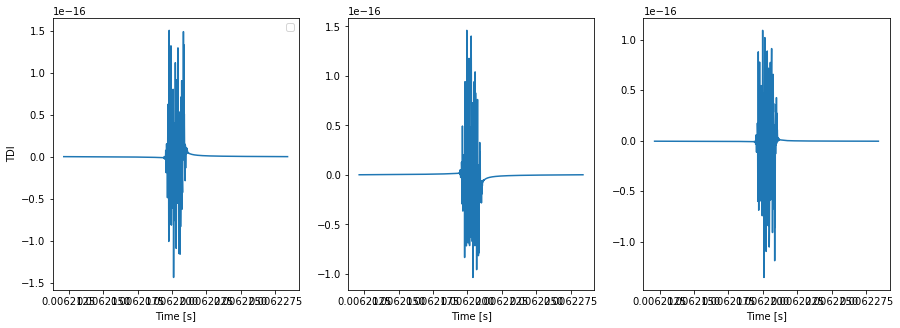

In [59]:
GB = fastGB.FastGB(delta_t=dt, T=t_max, orbits=lisa_orbits) # in seconds
Xs, Ys, Zs = GB.get_fd_tdixyz(template=pGB, oversample=4, simulator='synthlisa')

plt.figure(figsize=(15, 5))
for j, d in enumerate([Xs, Ys, Zs]):
    plt.subplot(1,3,j+1)
    plt.plot(d.f, d)
    plt.xlabel("Time [s]")
    if j==0:
        plt.ylabel("TDI")
        plt.legend()

### Generating noise free projected strain

In the following, projector.yArm (nt, 6) contains the projected strain signal for the 6 links, it can be saved in an h5 file to be given as input to LISANode. The LISANode configuration file has to be changed for:

```
LISA_GW_TYPE = 'file'
LISA_GW_FILE_FS = 0.2 #1 over dt 
```

Then: ```lisanode run lisanode:LISAWithTDI --gw-path my_gw_for_lisanode.h5```

The actual call to lisanode is shown below. 

In [60]:
GB = HpHc.type('AM_CVn', "GB", "TD_fdot")
GB.set_param(pGB)
projector = ProjectedStrain(lisa_orbits)
yArm = projector.arm_response(t_min, t_max, dt, GB.split())
projector.links

['1-2', '1-3', '2-1', '2-3', '3-1', '3-2']

In [61]:
projector.to_file("my_gw_for_lisanode.h5")

### From projected strain to TDI

In the following, we illustrate 3 ways of producing noise free TDI from the projected strain: 
- using the LDC time domain interpolated TDI
- using pyTDI
- using LISANode

which should all give the same result as the fast TDI code shown above. 

In [62]:
trange = np.arange(t_min, t_max, dt)
tdi_X = projector.compute_tdi_x(trange)


In [63]:
p = FD5.getSourceParameters(GWs[0])
td = FD5.getPreProcessTDI()
del_t = float(p.get("Cadence"))
Tobs = float(p.get("ObservationDuration"))

dt = del_t

# Build timeseries and frequencyseries object for X,Y,Z
tdi_ts = xr.Dataset(dict([(k, TimeSeries(td[:, n], dt=dt)) for k, n in [["X", 1], ["Y", 2], ["Z", 3]]]))
# tdi_ts = xr.Dataset(dict([(k,TimeSeries(tdi_ts[k][:,1], dt=dt)) for k in ["X", "Y", "Z"]]))
tdi_fs = xr.Dataset(dict([(k, tdi_ts[k].ts.fft(win=window)) for k in ["X", "Y", "Z"]]))

/home/stefan/.local/lib/python3.7/site-packages/LISAhdf5.py:508: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  params.addPar(ky,p.value,Str(p.attrs['Units']))
/home/stefan/.local/lib/python3.7/site-packages/LISAhdf5.py:742: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  d = np.copy(self.h5file['H5LISA/PreProcess/TDIdata'].value)
s


/home/stefan/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/stefan/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/stefan/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(<xarray.DataArray 'f' ()>
 array(0.00621914),
 <xarray.DataArray 'f' ()>
 array(0.0062214))

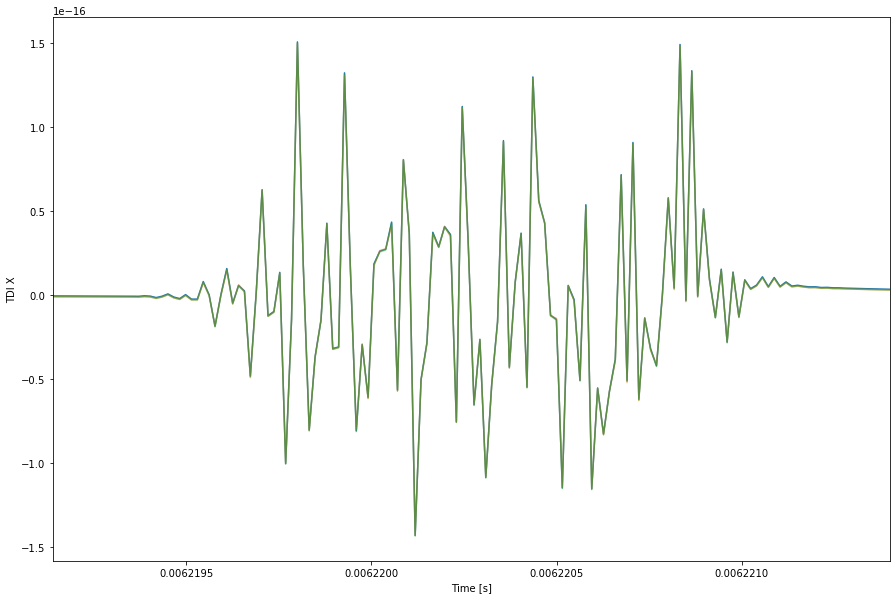

In [80]:

tdi_X_td = TimeSeries(tdi_X, dt=dt)
tdi_X_fd = tdi_X_td.ts.fft(win=window)
plt.figure(figsize=(15,10))
sl = slice(Xs.f.min(),Xs.f.max())
plt.plot(Xs.f, Xs, label="fast waveform")
plt.plot(tdi_X_fd.f, tdi_X_fd, label="strain to TDI", alpha=0.5)
plt.plot(tdi_fs['X'].f, tdi_fs['X'], label="data", alpha=0.5)
plt.xlabel("Time [s]")
plt.ylabel("TDI X")
plt.xlim(Xs.f.min()+0.000007,Xs.f.max()-0.000007)

### Using pyTDI

/home/stefan/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.
/home/stefan/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/stefan/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/stefan/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/stefan/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the ima

(<xarray.DataArray 'f' ()>
 array(0.00621914),
 <xarray.DataArray 'f' ()>
 array(0.0062214))

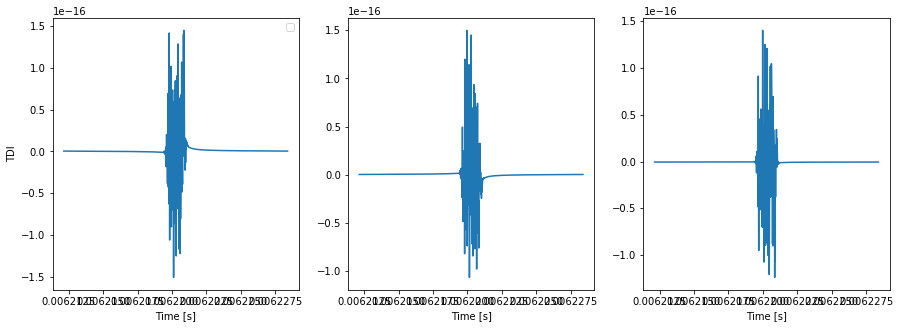

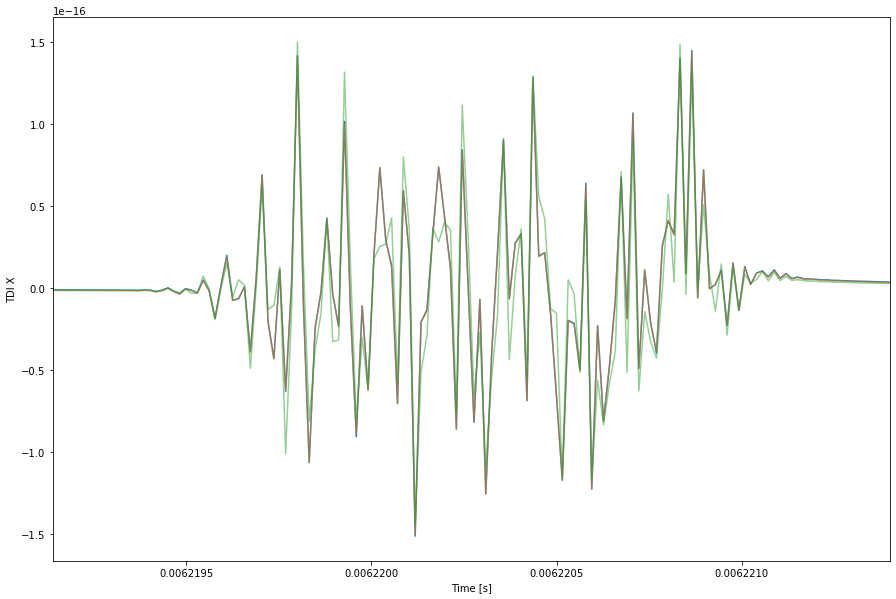

In [82]:
pGB = {'Amplitude': 6.373545164051205e-23, 'EclipticLatitude': -0.08222513098415238, 'EclipticLongitude': 2.1022552527635017, 'Frequency': 0.006220281478962882, 'FrequencyDerivative': 7.486504954481661e-16, 'Inclination': 0.6452098954792331, 'InitialPhase': 3.1415926535329115, 'Polarization': 2.9013532283888614}
GB = fastGB.FastGB(delta_t=dt, T=t_max, orbits=lisa_orbits) # in seconds
Xs, Ys, Zs = GB.get_fd_tdixyz(template=pGB, oversample=4, simulator='synthlisa')

plt.figure(figsize=(15, 5))
for j, d in enumerate([Xs, Ys, Zs]):
    plt.subplot(1,3,j+1)
    plt.plot(d.f, d)
    plt.xlabel("Time [s]")
    if j==0:
        plt.ylabel("TDI")
        plt.legend()

GB = HpHc.type('AM_CVn', "GB", "TD_fdot")
GB.set_param(pGB)
projector = ProjectedStrain(lisa_orbits)
yArm = projector.arm_response(t_min, t_max, dt, GB.split())
projector.links
trange = np.arange(t_min, t_max, dt)
tdi_X = projector.compute_tdi_x(trange)
tdi_X_td = TimeSeries(tdi_X, dt=dt)
tdi_X_fd = tdi_X_td.ts.fft(win=window)

plt.figure(figsize=(15,10))
sl = slice(Xs.f.min(),Xs.f.max())
plt.plot(Xs.f, Xs, label="fast waveform")
plt.plot(tdi_X_fd.f, tdi_X_fd, label="strain to TDI", alpha=0.5)
plt.plot(tdi_fs['X'].f, tdi_fs['X'], label="data", alpha=0.5)
plt.xlabel("Time [s]")
plt.ylabel("TDI X")
plt.xlim(Xs.f.min()+0.000007,Xs.f.max()-0.000007)

In [9]:
from pytdi.michelson import X1_ETA as X
data = {}
traveltimes = {}
for j, n in enumerate(projector.links):
    r,s = int(n[0]), int(n[-1])
    data[f"eta_{r}{s}"] = yArm[:,j]
    traveltimes[f"d_{r}{s}"] = lisa_orbits.compute_travel_time(s,r,trange) 
fs = 1/dt
data_X = X.build(data, traveltimes, fs, order=(3, 3))

(499900.0, 502600.0, -1.5e-23, 1.3184698185137956e-23)

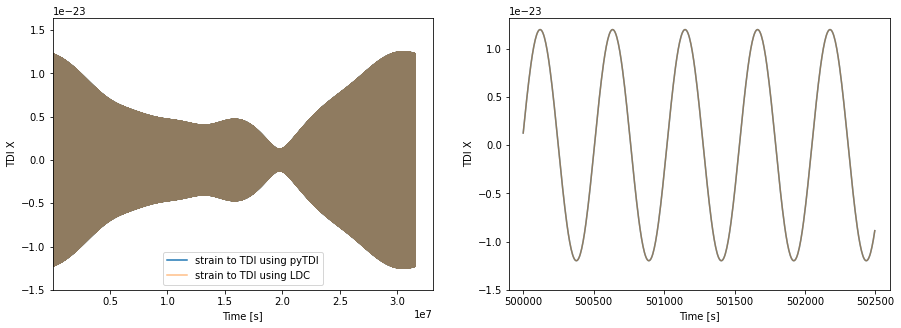

In [10]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(trange, data_X, label="strain to TDI using pyTDI")
plt.plot(trange, tdi_X, label="strain to TDI using LDC", alpha=0.5)
plt.xlabel("Time [s]")
plt.ylabel("TDI X")
plt.axis([1000, None, -1.5e-23, None])
plt.legend()
plt.subplot(122)
sl = slice(100000,100500)
plt.plot(trange[sl], data_X[sl], label="strain to TDI using pyTDI")
plt.plot(trange[sl], tdi_X[sl], label="strain to TDI using LDC", alpha=0.5)
plt.xlabel("Time [s]")
plt.ylabel("TDI X")
plt.axis([trange[sl.start]-100, trange[sl.stop]+100, -1.5e-23, None])

In [11]:
del projector, yArm, tdi_X, X, traveltimes, data, data_X, trange

## Calling LISANode

In the following, we call LISANode from here and load the resulting TDI output. 
Beware that the default configuration file is changed by this process. 

### Note about Orbits

One should use the same orbits and travel time for the projection and in the simulator. 
For now, this can be achieved by adjusting the LISANode configuration to : 

```
LISA_ORBIT_TYPE = 'ldc'
```

are running with the ```flags``` option to link LISANode to the LDC orbits and constants libraries as shown below.

Not all orbits parameters are propagated through the full LISA graph, such that it's not easy to change from the default ones. 

In a near future (LDC2b production), orbits file generated with the [lisaorbits](https://gitlab.in2p3.fr/lisa-simulation/orbits) software could be used on both sides.  


### Note about LISANode frequency sampling

For the time being, the LISANode compilation takes a lot of time and memory due to the sampling difference between input GW strain (0.2Hz) and LISA measurement (30Hz).  

This issue should be solved soon (again LDC2b production), with GW strain reading using the same buffering system as the one developed for reading orbits file. 


In [12]:
import lisanode.lisa
import os
dest = lisanode.lisa.__file__.replace('__init__', 'config')
os.system("cp %s %s"%("config.py", dest))

ldc_path = "/home/maude/soft/LDC/ldc/lisa/orbits" # set the path to LDC
flags = f"-L{ldc_path}/lib -I{ldc_path}/lib -I{ldc_path}/../../common/constants -lorbits"

output_file = "gb-tdi.h5"
ln_cmd = f"lisanode run --enable X Y Z --flags='{flags}' lisanode:LISAWithTDI -d 10000 -o {output_file} --gw-path my_gw_for_lisanode.h5"
ln_cmd += " --lasernoise-on-off 0 --backlinknoise-on-off 0 --telescopenoise-on-off 0 --accelnoise-on-off 0 --readoutnoise-on-off 0 --obpathlengthnoise-on-off 0 --usonoise-on-off 0 --modulationnoise-on-off 0 --rangingnoise-on-off 0"
ln_cmd
os.system(ln_cmd)

256

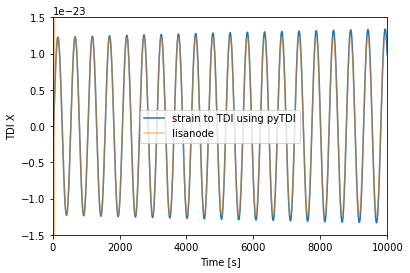

In [13]:
X_sim, attrs = hdfio.load_array("gb-tdi.h5")

sl = slice(0,int(10000/dt))
plt.figure()
plt.plot(Xs.t[sl], Xs[sl], label="strain to TDI using pyTDI")
plt.plot(X_sim["X"][:,0], X_sim["X"][:,1], label="lisanode", alpha=0.5)
plt.xlabel("Time [s]")
plt.ylabel("TDI X")
plt.axis([0, 10000, -1.5e-23, 1.5e-23])
plt.legend()


## Generating a massive black hole merger signal

In [14]:
cat, units = load_mbhb_catalog("/home/maude/soft/LDC/data_generation/test/data/catalog_1_yrs_full_1.dat")
pd.DataFrame(cat)

,EclipticLatitude,EclipticLongitude,PolarAngleOfSpin1,PolarAngleOfSpin2,Spin1,Spin2,Mass1,Mass2,CoalescenceTime,PhaseAtCoalescence,InitialPolarAngleL,InitialAzimuthalAngleL,Redshift,Distance
0,0.421998,3.291052,2.168084,2.478092,0.892382,0.570879,298995.0,287572.0,3.409125e+07,3.077585,1.256483,1.657101,2.83462,24363.400645
1,-0.577548,5.184169,2.184452,1.997086,0.995335,0.649950,281818.0,253224.0,1.515612e+08,0.310313,1.189669,5.352838,4.28557,39850.421054
2,-0.119126,2.113727,0.369755,1.680277,0.972603,0.990541,323283.0,184307.0,1.406976e+08,5.105357,2.433856,3.566298,3.50842,31441.059699
3,0.789798,1.409669,2.608840,0.789381,0.780164,0.998000,412288.0,215113.0,2.789121e+07,1.573143,0.099662,0.970856,2.17677,17708.063739
4,-0.111478,2.487932,1.604502,0.889584,0.980288,0.998000,231400.0,129322.0,6.191659e+07,5.435507,0.931624,5.375956,6.58376,65778.518657
5,-0.256023,0.900975,1.872914,0.795166,0.998000,0.995156,293838.0,149465.0,2.839082e+07,1.437696,0.252361,4.250104,2.57128,21664.498198
6,1.083933,4.596217,0.789460,1.811009,0.998000,0.998000,177190.0,84137.0,3.132388e+07,4.433687,2.393751,4.932560,5.36542,51867.527208


In [15]:
s_index = 3 # take the fourth, which merge before 1 yr 
pMBHB = dict(zip(cat.dtype.names, cat[s_index]))
pMBHB["ObservationDuration"] = t_max
pMBHB["Cadence"] = dt
MBHB = HpHc.type("demo", "MBHB", "IMRPhenomD")
MBHB.set_param(pMBHB)
projector = ProjectedStrain(lisa_orbits)
yArm = projector.arm_response(t_min, t_max, dt, MBHB.split())
projector.to_file("my_mbhb_for_lisanode.h5")

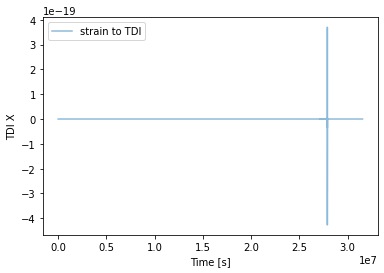

In [16]:
trange = np.arange(t_min, t_max, dt)
tdi_X = projector.compute_tdi_x(trange)

plt.figure()
plt.plot(trange, tdi_X, label="strain to TDI", alpha=0.5)
plt.xlabel("Time [s]")
plt.ylabel("TDI X")
plt.legend()